# Import a flat file into a SQLite database

In [1]:
import pyensae
%nb_menu

### Mix SQLite and DataFrame

When a dataset is huge (~3Gb), it takes some time to load it into a DataFrame. It is difficult to look at it in any tool (Python, Excel, ...) One option I usually do is to load it a SQL server if you have one. If you do not, then [SQLite](http://www.sqlite.org/) is the best option. Let's see how it works with a custom datasets.

In [2]:
import pyensae
pyensae.download_data("velib_vanves.zip", website = "xd")

    downloading of  http://www.xavierdupre.fr/enseignement/complements/velib_vanves.zip  to  velib_vanves.zip
    unzipped  velib_vanves.txt  to  .\velib_vanves.txt


['.\\velib_vanves.txt']

As this file is small (just an example), let's see how it looks like with a DataFrame.

In [4]:
import pandas
df = pandas.read_csv("velib_vanves.txt",sep="\t")
df.head(n=2)

,address,available_bike_stands,available_bikes,banking,bike_stands,bonus,contract_name,last_update,lat,lng,name,number,status,idr
0,112 RUE VERCINGETORIX - 75014 PARIS,65,2,0,67,0,Paris,15/07/2013 15:00,"48,83425925","2,313391647",14029 - GERGOVIE VERCINGETORIX,14029,OPEN,669
1,112 RUE VERCINGETORIX - 75014 PARIS,65,2,0,67,0,Paris,15/07/2013 15:05,"48,83425925","2,313391647",14029 - GERGOVIE VERCINGETORIX,14029,OPEN,1898


Then we import it into a SQLite3 database. The following function automatically guesses the table schema.

In [1]:
from pyensae.sql import import_flatfile_into_database
import_flatfile_into_database("velib_vanves.db3", "velib_vanves.txt", add_key="key")

processing file  velib_vanves.txt
  TextFile: opening file  velib_vanves.txt
  TextFile: closing file  velib_vanves.txt
   swith to str  ('address', (<class 'str'>, 70))  value  112 RUE VERCINGETORIX - 75014 PARIS
   swith to str  ('contract_name', (<class 'str'>, 10))  value  Paris
   swith to str  ('last_update', (<class 'str'>, 32))  value  15/07/2013 15:00
   swith to str  ('lat', (<class 'str'>, 22))  value  48,83425925
   swith to str  ('lng', (<class 'str'>, 22))  value  2,313391647
   swith to str  ('name', (<class 'str'>, 60))  value  14029 - GERGOVIE VERCINGETORIX
   swith to str  ('status', (<class 'str'>, 8))  value  OPEN
   guess {0: ('address', (<class 'str'>, 70)), 1: ('available_bike_stands', <class 'int'>), 2: ('available_bikes', <class 'int'>), 3: ('banking', <class 'int'>), 4: ('bike_stands', <class 'int'>), 5: ('bonus', <class 'int'>), 6: ('contract_name', (<class 'str'>, 10)), 7: ('last_update', (<class 'str'>, 32)), 8: ('lat', (<class 'str'>, 22)), 9: ('lng', (<cl

We check  the database exists:

In [6]:
import os
os.listdir(".")

['pyensae_flat2db3.ipynb',
 'pyensae_StockPrices.ipynb',
 'pyensae_velib.ipynb',
 'velib_vanves.db3',
 'velib_vanves.txt',
 'velib_vanves.zip']

On Windows, you can use [SQLiteSpy](http://www.yunqa.de/delphi/doku.php/products/sqlitespy/index) to visualize the created table. We use [pymysintall](http://www.xavierdupre.fr/app/pymyinstall/helpsphinx/index.html) to download it.

In [7]:
from pymyinstall.installcustom import install_sqlitespy
try:
    exe = install_sqlitespy()
except:
    # we skip an exception
    # the website can be down...
    exe = None
exe

SQLiteSpy, version  1.9.7
download  http://www.yunqa.de/delphi/lib/exe/fetch.php?hash=938481&media=http%3A%2F%2Fwww.yunqa.de%2Fdelphi%2Fdownloads%2FSQLiteSpy_1.9.7.zip
len  1828282
    unzipped  SQLiteSpy.exe  to  .\SQLiteSpy.exe
    unzipped  World.db3  to  .\World.db3


'.\\SQLiteSpy.exe'

We just need to run it (see [run_cmd](http://www.xavierdupre.fr/app/pyquickhelper/helpsphinx/pyquickhelper/loghelper/flog.html?highlight=run_cmd#loghelper.flog.run_cmd)).

In [8]:
from pyquickhelper import run_cmd
run_cmd("SQLiteSpy.exe velib_vanves.db3")

('', '')

You should be able to see something like:

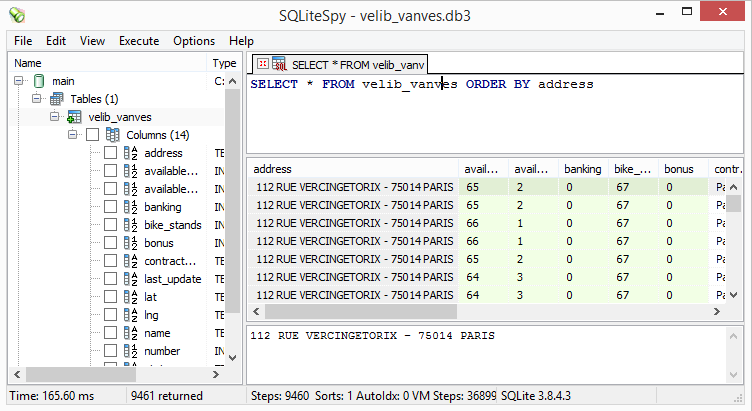

In [9]:
from pyquickhelper import NbImage
NbImage('img_nb_sqlitespy.png')

It is easier to use that tool to extract a sample of the data. Once it is ready, you can execute the SQL query in Python and converts the results into a DataFrame. The following code extracts a random sample from the original sets.

In [4]:
sql = """SELECT * FROM velib_vanves WHERE key IN ({0})"""

import random
from pyquickhelper import noLOG
from pyensae.sql import Database
db = Database("velib_vanves.db3", LOG = noLOG)
db.connect()
mx = db.execute_view("SELECT MAX(key) FROM velib_vanves")[0][0]
rnd_ids = [ random.randint(1,mx) for i in range(0,100) ]  # liste de 100 id aléatoires
strids  = ",".join( str(_) for _ in rnd_ids )
res = db.execute_view(sql.format (strids))
df = db.to_df(sql.format (strids))
db.close()
df.head()[["key","last_update","available_bike_stands","available_bikes"]]

,key,last_update,available_bike_stands,available_bikes
0,24,15/07/2013 16:55,66,1
1,26,15/07/2013 17:05,66,1
2,178,16/07/2013 05:45,49,18
3,220,16/07/2013 09:15,63,4
4,342,16/07/2013 19:25,61,6


<h3 id="mem">Memory Dump</h3>

Once you have a big dataset available in text format, it takes some time to load into memory and you need to do that every time you need it again after you closed your python instance.

In [9]:
with open("temp_big_file.txt","w") as f :
    f.write("c1\tc2\tc3\n")
    for i in range(0,10000000):
        x = [ i, random.random(), random.random() ]
        s = [ str(_) for _ in x ]
        f.write( "\t".join(s) + "\n" )
os.stat("temp_big_file.txt").st_size        

474285221

In [10]:
import pandas,time
t = time.clock()
df = pandas.read_csv("temp_big_file.txt",sep="\t")
print("duration (s)",time.clock()-t)

duration (s) 8.405750774129501


It is slow considering that many datasets contain many more features. But we can speed it up by doing a kind of memory dump with [to_pickle](http://pandas.pydata.org/pandas-docs/dev/generated/pandas.DataFrame.to_pickle.html).

In [11]:
t = time.clock()
df.to_pickle("temp_big_file.bin")
print("duration (s)",time.clock()-t)

duration (s) 2.2846547239112738


And we reload it with [read_pickle](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.io.pickle.read_pickle.html):

In [12]:
t = time.clock()
df = pandas.read_pickle("temp_big_file.bin")
print("duration (s)",time.clock()-t)

duration (s) 0.7951709542244885


It is 10 times faster and usually smaller on the disk.